In [89]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library
sys.path.append(os.path.abspath("../")) 

import pandas as pd

IMAGE_DIR = os.path.join(ROOT_DIR, "dataset-master")
if not os.path.exists(IMAGE_DIR):
    os.mkdir(IMAGE_DIR)
REPO_DIR = os.path.join(ROOT_DIR, "maskrcnn-master")

import pandas as pd
import os
import json
import colorsys
import random
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import imageio
from matplotlib import patches
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sample ids and split Train/Val 

In [91]:
from os import walk
sample_ids = []
for (dirpath, dirnames, filenames) in walk(os.path.join(IMAGE_DIR, "JPEGImages")):
    for filename in filenames:
        sample_ids.append(filename[:-4])
    break
print(f"Samples in total {len(sample_ids)}")
random.shuffle(sample_ids)
cic = {"train": sample_ids[:300], "val": sample_ids[300:]}
print(f"Samples in train {len(set(cic['train']))}, Samples in val {len(set(cic['val']))}")
print(f"Overlapping samples {len(set(cic['train']) & set(cic['val']))}")
with open(os.path.join(REPO_DIR, "image_collection_blood_cells.json"), 'w') as fp:
    json.dump(cic, fp)

Samples in total 366
Samples in train 300, Samples in val 66
Overlapping samples 0


In [5]:
image_path = os.path.join(IMAGE_DIR, "JPEGImages/BloodImage_00000.jpg")

In [6]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
image.shape

(480, 640, 3)

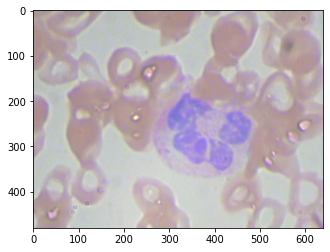

In [8]:
plt.imshow(image)

In [55]:
annotation_path = os.path.join(IMAGE_DIR, "Annotations/BloodImage_00000.xml")

In [56]:
from utils.utils import load_xml
annos, shape = load_xml(annotation_path)

In [57]:
masks, class_names = convert_annotations(annos, shape)

In [58]:
masks.shape

(480, 640, 11)

In [72]:
np.max(masks)

127

In [60]:
class_names

['RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC', 'RBC']

(480, 640, 3) (480, 640, 11)


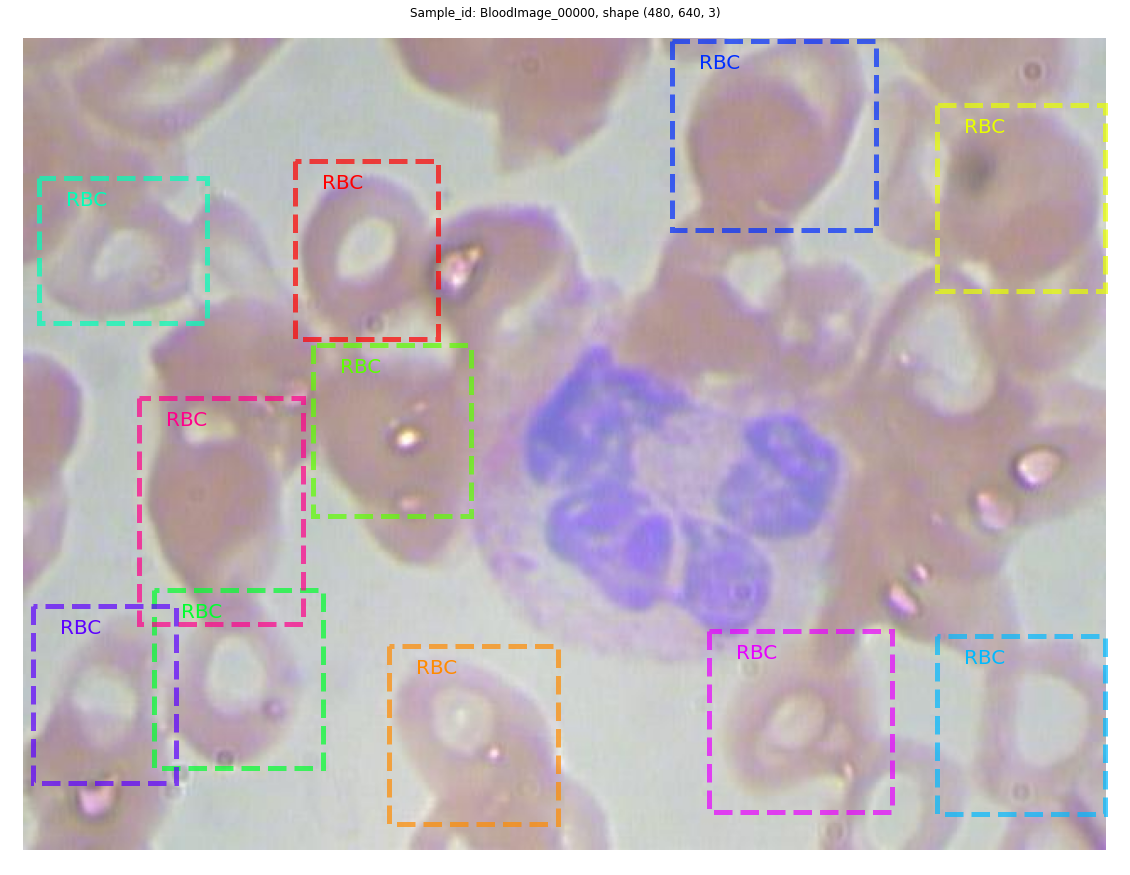

In [82]:
visualize_sample("BloodImage_00000", IMAGE_DIR)

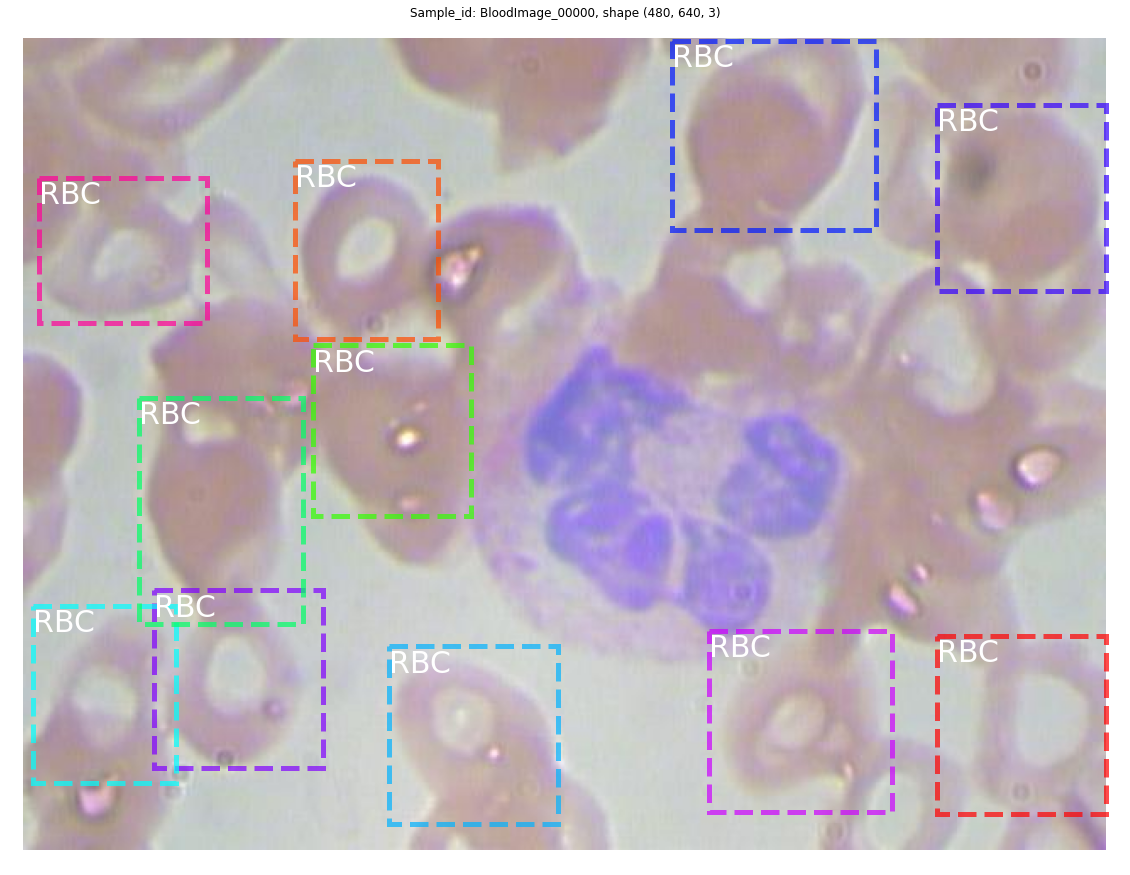

In [63]:
tree = ET.parse(annotation_path)
_, ax = plt.subplots(1, figsize=(20, 20))

colors = random_colors(20)

height, width = image.shape[:2]
ax.set_ylim(height + 10, -10)
ax.set_xlim(-10, width + 10)
ax.axis('off')
ax.set_title(f"Sample_id: BloodImage_00000, shape {image.shape}")

masked_image = image.astype(np.uint32).copy()
i = 0
for elem in tree.iter():
    if 'object' in elem.tag or 'part' in elem.tag:
        for attr in list(elem):
            if 'name' in attr.tag:
                name = attr.text
            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        x1 = int(round(float(dim.text)))
                    if 'ymin' in dim.tag:
                        y1 = int(round(float(dim.text)))
                    if 'xmax' in dim.tag:
                        x2 = int(round(float(dim.text)))
                    if 'ymax' in dim.tag:
                        y2 = int(round(float(dim.text)))
                
                p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=5,
                                  alpha=0.7, linestyle="dashed",
                                  edgecolor=colors[i], facecolor='none')
                ax.add_patch(p)
                ax.text(x1, y1 + 15, name,
                color='w', size=30, backgroundcolor="none")

                """if name[0] == "R":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 255, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 255, 0), 1)
                if name[0] == "W":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (0, 0, 255), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (0, 0, 255), 1)
                if name[0] == "P":
                    cv2.rectangle(image, (xmin, ymin),
                                (xmax, ymax), (255, 0, 0), 1)
                    cv2.putText(image, name, (xmin + 10, ymin + 15),
                            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image.shape[0], (255, 0, 0), """

        i += 1

ax.imshow(image.astype(np.uint8))
